# Pandas. Доверительный интервал. Меры различий

In [72]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Callable

1) Загрузка и первичная предобработка

- Загрузить данные **orders.csv** и **visitors.csv** в датафреймы и записать в соответвующие переменные **orders** и **visitors**
- При считывании обоих файлов при помощи read_csv() установите параметр parse_dates=['date'] для перевода даты из типа str в Timestamp
- Удалить пересечения по клиентам (visitorId) в группе A и B (код можно взять из лекции, таблицу visitors не трогать в этом случае!) и записать результат в переменную **orders**

ВСЕ ПРИМЕРЫ ЕСТЬ В ЛЕКЦИИ

In [16]:
# ваш код
orders = pd.read_csv("orders.csv", parse_dates=['date'])
visitors = pd.read_csv("visitors.csv", parse_dates=['date'])

orders[:5]

,transactionId,visitorId,date,revenue,group
0,0,0,2021-03-15,1633,B
1,1,1,2021-03-15,659,B
2,2,1070,2021-03-15,411,A
3,3,3,2021-03-15,9688,B
4,4,4,2021-03-15,2221,B


In [15]:
unique_A = orders[orders["group"] == "A"]["visitorId"].unique()
unique_B = orders[orders["group"] == "B"]["visitorId"].unique()

orders = [~orders["visitorId"].isin(np.intersect1d(unique_A, unique_B))]

2) Создать новую таблицу **orders_group**, произведя группировку таблицы **orders** по полям 'date', 'group' и подсчитав: 
- кол-во уникальных транзакций
- кол-во уникальных клиентов
- сумму прибыли revenue 

Далее объединить получившийся датасет после группировки с таблицей **visitors** по полям 'date' и 'group' и записать в переменную **orders_group**

ВСЕ ПРИМЕРЫ ЕСТЬ В ЛЕКЦИИ

In [27]:
orders_group = orders.groupby(["date", "group"]).agg(
    {"transactionId": "nunique", "visitorId": "nunique", "revenue": "sum"})

orders_group = pd.merge(orders_group, visitors, on=["date", "group"])
orders_group[:5]

orders_group.rename(
    columns={"transactionId": "trans_count", "visitorId": "vis_count"}, inplace=True)
orders_group[:5]

,date,group,trans_count,vis_count,revenue,visitors
0,2021-03-01,A,24,20,147184,682
1,2021-03-01,B,21,20,100522,631
2,2021-03-02,A,20,19,93141,564
3,2021-03-02,B,24,23,164593,560
4,2021-03-03,A,24,24,111486,410


3) Создайте новую колонку **purchase_mean** в таблице **orders_group** - средний чек, разделив сумму дохода на кол-во уникальных транзакци (пример в лекции)

In [30]:
orders_group["purchase_mean"] = (
    orders_group["revenue"]/orders_group["trans_count"]).round(2)
orders_group[:5]

,date,group,trans_count,vis_count,revenue,visitors,purchase_mean
0,2021-03-01,A,24,20,147184,682,6132.67
1,2021-03-01,B,21,20,100522,631,4786.76
2,2021-03-02,A,20,19,93141,564,4657.05
3,2021-03-02,B,24,23,164593,560,6858.04
4,2021-03-03,A,24,24,111486,410,4645.25


4) Создайте две переменные **orders_group_a** и **orders_group_b**, куда запишите данные группы А и группы B соответственно (пример в лекции)

In [31]:
# ваш код
orders_group_a = orders_group[orders_group["group"] == "A"]
orders_group_b = orders_group[orders_group["group"] == "B"]

5) Построить графики распределений (histplot) среднего чека отдельно для A и B групп.

Отобразить графики **в ОДНОЙ строке, но в РАЗНЫХ столбцах и с РАЗНЫМИ цветами**

<AxesSubplot: xlabel='purchase_mean', ylabel='Count'>

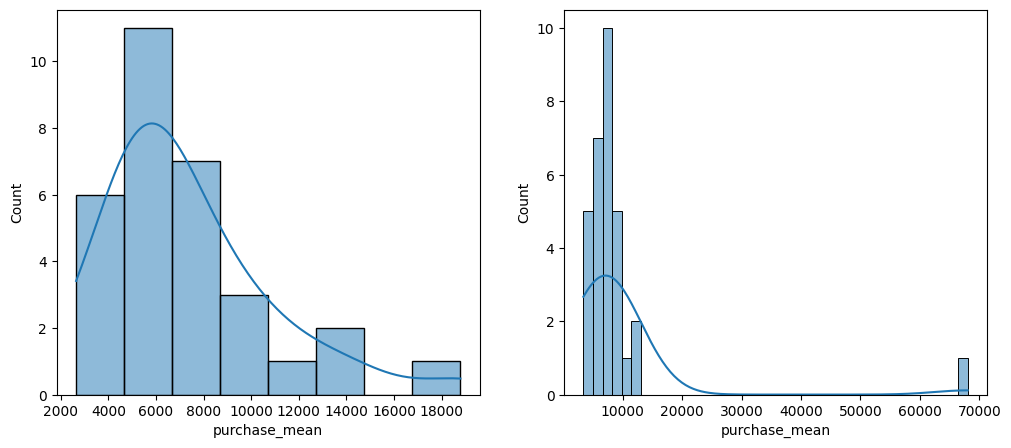

In [41]:
fig, axes = plt.subplots(ncols=2, figsize = (12,5))

sns.histplot(orders_group_a["purchase_mean"], kde=True, ax=axes[0])
sns.histplot(orders_group_b["purchase_mean"], kde=True, ax=axes[1])

6) Проверка на нормальность:

- Напишите функцию для проверки на нормальность по критерию Шапиро-Уилка, которая будет выводить **относится ли распределение к нормальному или не**т, а также **выводить значение p-value с 3мя знаками после запятой**

- Проверьте распределения среднего чека (признак purchase_mean) **для группы A** на нормальность с использованием написанной функции
- Проверьте распределения среднего чека (признак purchase_mean) **для группы B** на нормальность с использованием написанной функции

In [54]:
def check_norm(sample: pd.Series) -> None:
    """
    Проверка выборки на нормальность критерием Шапиро-Уилка
    """
    p_value = stats.shapiro(sample).pvalue
    
    if p_value > 0.05:
        print(f"Нормальное распределение\n{round(p_value, 3)}")
    else:
        print(f"Ненормальное распределение\n{round(p_value, 3)}")

check_norm(orders_group_a["purchase_mean"].values)
check_norm(orders_group_b["purchase_mean"].values)

31
Ненормальное распределение
0.002
Ненормальное распределение
0.0


7) Напишите функцию **get_interval()** (пока без применения), которая бы:

- вычисляла доверительный интервал **при помощи z критерия** при известной дисперсии
- вычисляла доверительный интервал **при помощи t-критерия**, если дисперсия неизвестна
- выводила как и сам интервал, так и условие: известна дисперсия, либо не известна
- также нужно учесть, что функция должна принимать на вход:
    - данные
    - дисперсию (при известной дисперсии) - по умолчанию = None
    - уровень доверия по умолчанию $\beta=0.95$ **здесь аккуратнее!!** см в лекции почему
    
У вас должна получиться **ОДНА функция**, которая вычисляет интервал для разных случаев

In [65]:
def get_interval(sample: pd.Series, D: float = None, beta: float = 0.95) -> None:
    """
    Вывод доверительного интервала для выборки
    """
    if D == None:
        s = stats.sem(sample, ddof=1)
        t_value = stats.t.ppf((1+beta)/2, sample.shape[0])
        intervals = (sample.mean() - t_value*s, sample.mean() + t_value*s)
        print(f"Дисперсия не известна\n{intervals}")
    else:
        std = stats.sem(sample, ddof=0)
        z_value = stats.norm.ppf(q=(1+beta)/2)
        intervals = (sample.mean() - z_value*std, sample.mean() + z_value*std)
        print(f"Дисперсия известна\n{intervals}")

8) Найти доверительные интервалы **для каждой из групп A и B по отдельности** при помощи написанной функции **get_interval()** из задания №7 для признака **purchase_mean** при уровне доверия $\beta=0.99$%!!!:
   - при известной дисперсии

- За известную дисперсию возьмите значение для группы A = 11088900
- За известную дисперсию возьмите значение для группы B = 122102500


**Будьте внимательны** в лекции брали пример с 95%, то с каждой стороны мы брали по 2.5%

In [67]:
get_interval(orders_group_a["purchase_mean"], D=11088900, beta=0.99)
get_interval(orders_group_b["purchase_mean"], D=122102500, beta=0.99)

Дисперсия известна
(5718.493236895684, 8941.991279233347)
Дисперсия известна
(4070.6726386818673, 14196.366716156845)


9) Найти доверительные интервалы **для каждой из групп A и B по отдельности** при помощи написанной функции **get_interval()** из задания №7 для признака **purchase_mean** для $\beta=0.99$%!!!:
   - при неизвестной дисперсии
   
**Будьте внимательны** в лекции брали пример с 95%, то с каждой стороны мы брали по 2.5%

In [79]:
get_interval(orders_group_a["purchase_mean"], beta=0.99)
get_interval(orders_group_b["purchase_mean"], beta=0.99)

Дисперсия не известна
(5584.857027359267, 9075.627488769764)
Дисперсия не известна
(3650.892834982097, 14616.146519856615)


10) Написать функцию **bootstrap_interval()** (пока без применения) для вычисления интервала как из задания №7, но теперь только с использованием **Bootstrap**

- функция должна принимать:
    - данные
    - функцию для усреднения (среднее, медиана и тд), по умолчанию np.mean
    - уровень доверия по умолчанию $\beta=0.95$ 
- вам уже дана функция из лекции bootstrap_resample(), вы ее можете использовать для bootstrap_interval() для генерации выборок
- необходимо, чтобы функция **возвращала доверительный интервал**

**ВАЖНО:**
Описывать внутри вашей функции функцию bootstrap_resample() не нужно!

In [73]:
def bootstrap_resample(data: pd.Series,
                       function: Callable,
                       count_generate: int = 1000,
                       random_state: int = 10) -> list:
    """
    Bootstrap
    """
    sample_size = len(data)
    np.random.seed(random_state)
    bootstrap_sample = []

    for i in range(count_generate):
        # replace - параметр возвращения
        sample = data.sample(sample_size, replace=True)
        bootstrap_sample.append(function(sample))

    return bootstrap_sample

In [102]:
def bootstrap_interval(data: pd.Series, function: Callable = np.mean, beta=0.95) -> tuple:
    """
    Bootstrap
    """
    bootstrap_sample = bootstrap_resample(data, function)
    perc_1 = np.quantile(bootstrap_sample, (1 - beta)/2)
    perc_2 = np.quantile(bootstrap_sample, (1 + beta)/2)
    
    return (perc_1, perc_2)

11) Найти доверительный интервал **для каждой из групп A и B отдельно** для признака **purchase_mean** при помощи написанной функции из задания №10 при уровне доверия $\beta=0.99$

In [103]:
print(bootstrap_interval(orders_group_a["purchase_mean"], beta=0.99))
print(bootstrap_interval(orders_group_b["purchase_mean"], beta=0.99))

(5924.523293548386, 9036.030098387097)
(6466.538561290322, 16710.672940322584)


12) Выберите **ТОЛЬКО ОДИН** из статистических методов (t-критерий или Манна-Уитни) для **сравнения средних двух выборок** (группы A с группой B) по признаку **purchase_mean** согласно проведенным выше исследованиям с **учетом типа распределения обеих выборок и их размера**. 

Схожи ли будут выборки? Взять уровень значимости $\alpha=0.05$

In [111]:
orders_group_b["purchase_mean"].shape[0]

31

In [109]:
p_value = stats.mannwhitneyu(
    orders_group_a["purchase_mean"], orders_group_b["purchase_mean"], method="exact").pvalue

if p_value > 0.05:
    print(f"Средние схожи\np_value = {p_value}")
else:
    print(f"Средние различны\np_value = {p_value}")

Средние схожи
p_value = 0.4088449848294004


13) Проделайте то же самое сравнение, но уже при помощи **Bootstrap**:
- Используйте функцию **bootstrap_compare()** из лекции
- В качестве **function возьмите np.median**!!!

Выведите график **РАСПРЕДЕЛЕНИЯ** (не частоты значений) разности двух групп (пример в лекции), а также доверительный интервал

Схожи ли результаты эксеримента?

In [113]:
def bootstrap_resample_2(data1: pd.Series,
                         data2: pd.Series,
                         function: Callable,
                         count_generate: int = 1000,
                         random_state: int = 10) -> list:
    """
    Bootstrap compare
    """
    sample_size = max(len(data1), len(data2))
    np.random.seed(random_state)
    bootstrap_sample = []

    for i in range(count_generate):
        # replace - параметр возвращения
        sample1 = data1.sample(sample_size, replace=True)
        sample2 = data2.sample(sample_size, replace=True)
        bootstrap_sample.append(function(sample1) - function(sample2))

    return bootstrap_sample

Средние схожи
p_value = 0.3071080486917315


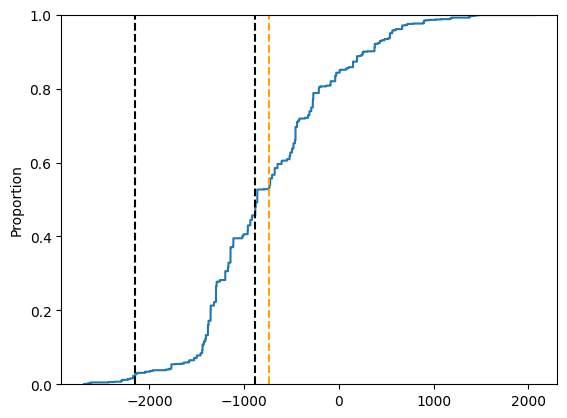

In [129]:
def bootstrap_compare(data1: pd.Series,
                      data2: pd.Series,
                      function: Callable = np.mean,
                      alpha=0.05) -> tuple:
    """
    Bootstrap compare
    """
    bs_sample = bootstrap_resample_2(data1, data2, function)

    perc_1 = np.quantile(bs_sample, alpha/2)
    perc_2 = np.quantile(bs_sample, (1 - alpha)/2)
    ci = (perc_1, perc_2)

    p1 = stats.norm.cdf(0, loc=np.mean(bs_sample), scale=np.std(bs_sample))
    p2 = 1 - p1
    p_value = min(p1, p2) * 2
    
    if p_value > alpha:
        print(f"Средние схожи\np_value = {p_value}")
    else:
        print(f"Средние различны\np_value = {p_value}")

    return bs_sample, ci, p_value


sample, ci, p_value = bootstrap_compare(
    orders_group_a["purchase_mean"], orders_group_b["purchase_mean"], function=np.median)

sns.ecdfplot(sample)
plt.axvline(np.mean(sample), ls = '--', color = "orange")
plt.vlines(ci, ymin=0, ymax=1, ls = '--', color = 'black')